In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Multilingual-MiniLM-L12-H384

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import re
# 1. Load and Prepare the Dataset
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 2. Load Your Data
# Assuming 'naijahate.csv' is the dataset file
train_df = pd.read_csv("/kaggle/input/sample-data/main_df_train.csv")
test_df = pd.read_csv("/kaggle/input/sample-data/main_df_test.csv")

In [ ]:
train_df["class"].value_counts()

class
0    7028
1    6264
2    5708
Name: count, dtype: int64

In [ ]:
test_df["class"].value_counts()

class
0    2972
1    2652
2    2524
Name: count, dtype: int64

In [ ]:
train_df.head()

,class,text,clean_text
0,0,Ana m alọta.,ana m alọta.
1,0,"Haka ne, Pessi da kocin, suna yiwuwa suna da w...","haka ne, pessi da kocin, suna yiwuwa suna da w..."
2,2,Gaskiya ba na zargi gwamnati ba Na san PPL na ...,gaskiya ba na zargi gwamnati ba na san ppl na ...
3,1,"Ladies, ya kamata ka barci da dare kuma ba twe...","ladies, ya kamata ka barci da dare kuma ba twe..."
4,0,"Ina kishi da Ds swaggg, shi ne m m mkkkkkkkkkk...","ina kishi da ds swaggg, shi ne m m mkkkkkkkkkk..."


In [ ]:
test_df.head()

,class,text,language,clean_text
0,0,"Nigerian Army begs Boko Haram, ISWAP terrorist...",english,"nigerian army begs boko haram, iswap terrorist..."
1,0,I agreee 😁😁,english,i agreee
2,0,"Right. Crime pays, right?",english,"right. crime pays, right?"
3,1,"Na yi wa 'yan'uwana mata 'yan Najeriya, na yi ...",hausa,"na yi wa 'yan'uwana mata 'yan najeriya, na yi ..."
4,0,"""Ya'ya mata idan bai girmama ku isa ya jira ba...",hausa,"""ya'ya mata idan bai girmama ku isa ya jira ba..."


In [ ]:
# Preprocess Data (e.g., extracting features and labels)
train_texts = train_df['clean_text'].values
train_labels = train_df['class'].values

val_texts = test_df['clean_text'].values
val_labels = test_df['class'].values

In [ ]:
# 3. Load Pre-trained XLM-R Tokenizer
# tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
MAX_LEN = 128

In [ ]:
#2. Load Pre-trained mBERT Tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384')
model = AutoModelForSequenceClassification.from_pretrained('microsoft/Multilingual-MiniLM-L12-H384', num_labels=3)

# MAX_LEN = 128

# Create DataLoaders
train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# # Create DataLoaders
# train_loader = DataLoader(train_texts, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_texts, batch_size=16, shuffle=False)

# 3. Initialize mBERT Model for Classification
# model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)  # Assuming 3 classes (hate, offensive, neutral)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 4. Set Up Optimizer and Scheduler
optimizer = torch.optim.AdamW([
    {'params': model.base_model.embeddings.parameters(), 'lr': 1e-5},
    {'params': model.base_model.encoder.layer[:6].parameters(), 'lr': 1e-5},
    {'params': model.base_model.encoder.layer[6:].parameters(), 'lr': 2e-5},
    {'params': model.classifier.parameters(), 'lr': 3e-5}
])

total_steps = len(train_loader) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 6. Define Training and Evaluation Loops
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    total_loss = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(data_loader)

def eval_model(model, data_loader, device):
    model = model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

accumulation_steps = 4  # Accumulate gradients over 4 batches

for epoch in range(10):
    model.train()
    total_loss = 0

    for i, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / accumulation_steps  # Scale loss
        total_loss += loss.item()

        loss.backward()
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")
# 8. Evaluate the Model
preds, true_labels = eval_model(model, val_loader, device)

# Print Evaluation Report
print(classification_report(true_labels, preds))


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.2613811517504329
Epoch 2, Loss: 0.24357201280668128
Epoch 3, Loss: 0.2266542227430777
Epoch 4, Loss: 0.21313848253653106
Epoch 5, Loss: 0.20170452674029252
Epoch 6, Loss: 0.19168226678012196
Epoch 7, Loss: 0.1835635799086756
Epoch 8, Loss: 0.17779404111833685
Epoch 9, Loss: 0.1711529837513612
Epoch 10, Loss: 0.16715928123203994
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      2972
           1       0.57      0.56      0.56      2652
           2       0.62      0.63      0.63      2524

    accuracy                           0.61      8148
   macro avg       0.61      0.61      0.61      8148
weighted avg       0.61      0.61      0.61      8148



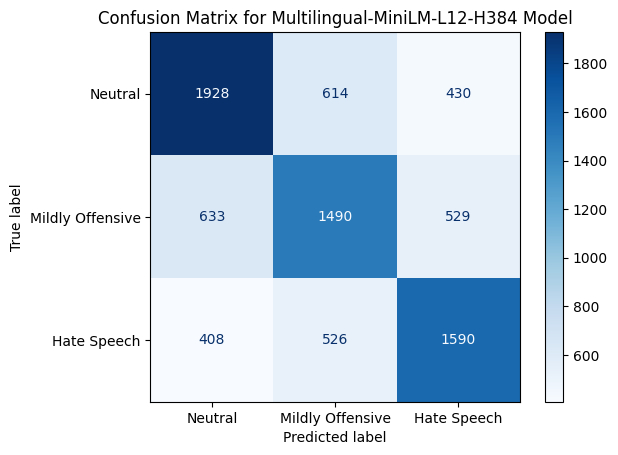

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Display the confusion matrix using a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Mildly Offensive', 'Hate Speech'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Multilingual-MiniLM-L12-H384 Model')
plt.show()

In [ ]:
igbo_df = test_df[test_df["language"]=="igbo"]
val_texts = igbo_df['clean_text'].values
val_labels = igbo_df['class'].values

val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer, MAX_LEN)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 8. Evaluate the Model
preds, true_labels = eval_model(model, val_loader, device)

# Print Evaluation Report
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61       743
           1       0.55      0.51      0.53       663
           2       0.61      0.64      0.62       631

    accuracy                           0.59      2037
   macro avg       0.59      0.59      0.59      2037
weighted avg       0.59      0.59      0.59      2037



In [ ]:
yor_df = test_df[test_df["language"]=="yoruba"]
val_texts = yor_df['clean_text'].values
val_labels = yor_df['class'].values

val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer, MAX_LEN)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 8. Evaluate the Model
preds, true_labels = eval_model(model, val_loader, device)

# Print Evaluation Report
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       743
           1       0.51      0.52      0.51       663
           2       0.57      0.58      0.58       631

    accuracy                           0.56      2037
   macro avg       0.56      0.56      0.56      2037
weighted avg       0.56      0.56      0.56      2037



In [ ]:
hau_df = test_df[test_df["language"]=="hausa"]
val_texts = hau_df['clean_text'].values
val_labels = hau_df['class'].values

val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer, MAX_LEN)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 8. Evaluate the Model
preds, true_labels = eval_model(model, val_loader, device)

# Print Evaluation Report
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.62      0.61      0.62       743
           1       0.52      0.56      0.54       663
           2       0.60      0.56      0.58       631

    accuracy                           0.58      2037
   macro avg       0.58      0.58      0.58      2037
weighted avg       0.58      0.58      0.58      2037



In [ ]:
eng_df = test_df[test_df["language"]=="english"]
val_texts = eng_df['clean_text'].values
val_labels = eng_df['class'].values

val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer, MAX_LEN)

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 8. Evaluate the Model
preds, true_labels = eval_model(model, val_loader, device)

# Print Evaluation Report
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       743
           1       0.70      0.66      0.68       663
           2       0.73      0.73      0.73       631

    accuracy                           0.73      2037
   macro avg       0.73      0.73      0.73      2037
weighted avg       0.73      0.73      0.73      2037

